# WeRateDogs Twitter Data Wrangling

## Table of Contents
<ul>
<li><a href="#intro">Data Gathering</a></li>
<li><a href="#wrangling">Data Assessment</a></li>
<li><a href="#eda">Data Cleaning</a></li>
<li><a href="#conclusions">Data Storing</a></li>
</ul>

In [93]:
#Libraries imported

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from bs4 import BeautifulSoup
import tweepy as tw
import json
import glob
import datetime as dt
import re
import seaborn as sns

%matplotlib inline

<a id='intro'></a>
## Data Gathering

In this project, we will gather data from three different sources in order to analyze and obtain insights from the WeRateDogs Twitter.

First of all, the WeRateDogs twitter archive has been given to us and downloaded manually.


In [94]:
df_twitter_archive_enhanced = pd.read_csv("twitter-archive-enhanced.csv")

The second data set used is a file with tweet image predictions. This data is downloaded programmatically using it's URL.

In [95]:
data_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(data_url)

file = open('image-predictions.tsv', 'wb')

file.write(response.content)

file.close()

In order to complement the twitter archive given, we will use the tweet IDs to query the Twitter API and extract each tweet's entire set of JSON data.

First, let's extract the tweet IDs from the image predictions archive.

In [96]:
df_image_preditions = pd.read_csv("image-predictions.tsv", sep='\t')

display(df_image_preditions.columns)

tweet_ids = df_image_preditions.tweet_id

display("There are {} unique Tweet IDs".format(len(tweet_ids.unique())))

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

'There are 2075 unique Tweet IDs'

Now that we have the tweet IDs in the "tweet_ids" variable, we will query the Twitter API in the next cell.

In [46]:
twitter_keys = {
        'consumer_key':        '',
        'consumer_secret':     '',
        'access_token_key':    '',
        'access_token_secret': ''
    }

#Setup access to API
auth = tw.OAuthHandler(twitter_keys['consumer_key'], twitter_keys['consumer_secret'])
auth.set_access_token(twitter_keys['access_token_key'], twitter_keys['access_token_secret'])

#Connect to the API using rate limits to query
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

filename = 'tweet_json.txt'

not_available = []

#Create .txt file with Tweet JSONs
with open(filename, 'w') as outfile:
    for i in tweet_ids:
        try:
            #Get the data as JSON
            status = api.get_status(str(i))
            json_str = json.dumps(status._json)
            #Add each JSON data into a new line
            outfile.write("%s\n" % json_str)
        except tw.TweepError:
            #If there is an error with the tweet ID, print and save it in a list
            not_available.append(str(i))
            print(str(i))


680055455951884288


Rate limit reached. Sleeping for: 79


754011816964026368
759566828574212096
771004394259247104
779123168116150273
802247111496568832
829374341691346946


Rate limit reached. Sleeping for: 11


837012587749474308
837366284874571778
842892208864923648
844704788403113984
851953902622658560
861769973181624320
872261713294495745
873697596434513921
888202515573088257


Then, we will read this .txt file line by line and export it into a pandas DataFrame with tweet ID, retweet count, and favorite count. In order to locate this parameters in the JSON data entries easier, we will define the following function that prints that type of data in a much easier form.

In [97]:
def jprint(obj):
    text = json.dumps(obj, sort_keys = True, indent = 6)
    return text

The next cell is used to create a dataframe of the tweet parameters used.

In [98]:
filename = 'tweet_json.txt'

#Create a new DataFrame

df_list = []

#Open JSON File line by line
with open(filename, 'r') as openfile:
    for line in openfile:
        #Read each line as dictionary
        json_object = json.loads(line)
        #print(jprint(json_object))
        #Assign the needed parameters to variables
        ids = json_object['id_str']
        retweet_count = json_object['retweet_count']
        favorite_count = json_object['favorite_count']
        #Add variables to the new dataframe
        df_list.append({'tweet_id': ids,
                       'retweet_count': retweet_count,
                       'favorite_count': favorite_count})
        
df_tweet_json = pd.DataFrame(df_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])

display(df_tweet_json.head())
display(df_tweet_json.info())

,tweet_id,retweet_count,favorite_count
0,666020888022790149,443,2343
1,666029285002620928,41,118
2,666033412701032449,39,107
3,666044226329800704,122,259
4,666049248165822465,38,93


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 3 columns):
tweet_id          2059 non-null object
retweet_count     2059 non-null int64
favorite_count    2059 non-null int64
dtypes: int64(2), object(1)
memory usage: 48.4+ KB


None

<a id='wrangling'></a>
## Data Assessment

In this section we will assess the gathered data visually and programatically for quality and tidiness issues.


### Quality Issues

First, let's take a look in the twitter-archive-enhanced data.

In [99]:
#Reading the data.

df_twitter_archive_enhanced = pd.read_csv("twitter-archive-enhanced.csv")

#General description of a dataset.

display(df_twitter_archive_enhanced)

print("The raw data contains {} rows and {} columns.".format(df_twitter_archive_enhanced.shape[0],df_twitter_archive_enhanced.shape[1]))

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


The raw data contains 2356 rows and 17 columns.


As we can see in the following cell, there are quality issues with this data set.

In [100]:
display(df_twitter_archive_enhanced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

None

In [101]:
display(df_twitter_archive_enhanced[['rating_numerator', 'rating_denominator']].describe())

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


1. The data set contains 78 tweet replies ("in_reply_to_status_id" and "in_reply_to_user_id" columns). 
2. There are 181 retweets ("retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp").
3. Column name "expanded_urls" is not descriptive enough as it determines whether the tweet has an image attached or not.
4. There are 2356-2297=59 tweets without images.
5. "timestamp" column data type should be datetime. We could also generate additional columns (year, month, day) in order to make better insights.
6. Column "tweet_id" data type should be treated as string as there are no numerical relationships between ids.
7. Tweet "text" column contains the URL of the tweet, which can cause problems during text analysis.
8. Ratings could be wrong, specially when there are multiple ratings per tweet.
9. Dog stages categorization could be wrong. 

### Tidiness Issues

The detected tidiness issues are the following:
    
1. "expanded_urls" column has multiple values in each row separated by commas.
2. Dog categorization variable is represented as 4 columns. We can collapse all 4 columns into a single one as it is only one variable.
3. All three data sets should be merged by "tweet_id" into a single database for further analysis.


In [102]:
print(df_twitter_archive_enhanced["expanded_urls"][10])

https://twitter.com/dog_rates/status/890006608113172480/photo/1,https://twitter.com/dog_rates/status/890006608113172480/photo/1


<a id='wrangling'></a>
## Data Cleaning

In this section we will clean the gathered data programatically to improve quality and tidiness.

First, it is recommended to make a copy of each dataframe.

In [103]:
df_clean_enhanced = df_twitter_archive_enhanced.copy()

df_clean_image = df_image_preditions.copy()

df_clean_json = df_tweet_json.copy()

### Quality Issues

1. To clean the tweet replies issues, we suggest to filter the column by the null values in the "in_reply_to_status_id" column.

In [104]:
df_clean_enhanced = df_clean_enhanced[df_clean_enhanced['in_reply_to_status_id'].isnull()]

display(df_clean_enhanced.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2278 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2278 non-null object
source                        2278 non-null object
text                          2278 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2278 non-null int64
rating_denominator            2278 non-null int64
name                          2278 non-null object
doggo                         2278 non-null object
floofer                       2278 non-null object
pupper                        2278 non-null object
puppo                         2278 non-null object
dtypes: float64(4), int64(3), obje

None

2. To clean the retweets, we suggest to filter the column by the null values in the "retweeted_status_id" column.

In [105]:
df_clean_enhanced = df_clean_enhanced[df_clean_enhanced['retweeted_status_id'].isnull()]

display(df_clean_enhanced.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

None

3. To make the "expanded_urls" column name more descriptive, we suggest to change it to "image_urls".

In [106]:
df_clean_enhanced = df_clean_enhanced.rename(columns={'expanded_urls': 'image_urls'})

4. In order to consider only those tweets with images, we will filter the dataframe by the non null "image_urls" column.

In [107]:
df_clean_enhanced = df_clean_enhanced[df_clean_enhanced['image_urls'].notnull()]

display(df_clean_enhanced.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2094 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2094 non-null object
source                        2094 non-null object
text                          2094 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
image_urls                    2094 non-null object
rating_numerator              2094 non-null int64
rating_denominator            2094 non-null int64
name                          2094 non-null object
doggo                         2094 non-null object
floofer                       2094 non-null object
pupper                        2094 non-null object
puppo                         2094 non-null object
dtypes: float64(4), int64(3), object(10)

None

5. The next cell changes the "timestamp" column data type to datetime and creates additional columns with the year, month and day information for further analysis.

In [108]:
df_clean_enhanced['timestamp'] = pd.to_datetime(df_clean_enhanced['timestamp'])

df_clean_enhanced['year'] = df_clean_enhanced['timestamp'].dt.year

df_clean_enhanced['month'] = df_clean_enhanced['timestamp'].dt.month

df_clean_enhanced['day'] = df_clean_enhanced['timestamp'].dt.day

display(df_clean_enhanced[['year', 'month', 'day']].describe())

,year,month,day
count,2094.000000,2094.000000,2094.000000
mean,2015.859599,7.061127,16.016714
std,0.691468,4.115519,8.923908
min,2015.000000,1.000000,1.000000
25%,2015.000000,3.000000,8.000000
50%,2016.000000,7.000000,16.000000
75%,2016.000000,11.000000,24.000000
max,2017.000000,12.000000,31.000000


6. The next cell changes the column "tweet_id" data type to string for both image and enhanced data sets.

In [109]:
df_clean_enhanced['tweet_id'] = df_clean_enhanced['tweet_id'].astype(str)

df_clean_image['tweet_id'] = df_clean_image['tweet_id'].astype(str)

display(type(df_clean_enhanced['tweet_id'][0]))
display(type(df_clean_image['tweet_id'][0]))

str

str

7.  In order to fix the ratings numerator and denominator, we need to check the "text" column. Dog ratings are expressed as a number (numerator), a slash ("/") and another number(denominator). Ideally, we should search for this using a regular expression in the tweet "text" column. However, we found that in the "text" column there is also de tweet url, so first we need to get rid of this.

In [110]:
#String that represents the start of an URL
url_type = 'https://'

#Find the location of this string in the "text" column
df_clean_enhanced["remove_urls"] = df_clean_enhanced.text.str.find(url_type)

#Slice and save into "text_wihout_url" column every tweet text with the location of the url.
L_text_without_url = []
for i, value in df_clean_enhanced["remove_urls"].items():
    L_text_without_url.append(df_clean_enhanced["text"][i][0:int(value)-1])

df_clean_enhanced["text_without_url"] = L_text_without_url

#Testing if the code works
print(df_clean_enhanced["text"][0])
print(df_clean_enhanced["text_without_url"][0])

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10


8. To find the ratings in the text, we will use a regular expresion pattern. The pattern consists in multiple numbers separated by a single slash. The "findall" method will find every string that matches this criteria and store it in a list. We used this method because there could be more than a single rating per tweet.

In [111]:
fraction_pattern = r"([0-9]*/{1}[0-9]*)"

ratings = df_clean_enhanced.text_without_url.str.findall(fraction_pattern)

display(ratings)

0       [13/10]
1       [13/10]
2       [12/10]
3       [13/10]
4       [12/10]
         ...   
2351     [5/10]
2352     [6/10]
2353     [9/10]
2354     [7/10]
2355     [8/10]
Name: text_without_url, Length: 2094, dtype: object

Now we need to check for inconsistencies. First, we want to check those tweets with more than one rating and the tweets with a rating denominator different from 10. Also, we would like to check if the provided rating is different from the one extracted using the regular expression presented before. The following cells shows this criteria in a couple lines of code. We also print the indices, our rating, the rating provided and the tweet text to check if it is correct or not. The indices will be used to replace the correct ratings in the dataframe for each case.

In [112]:
count_multiple_ratings = 0

count_10_denominators = 0

count_different_ratings = 0


for k, val in ratings.items():
    #Check for more than one rating
    if len(val) > 1:
        display("Index {}: Extracted rating: {} Provided: {}. Tweet: {}".format(k,
                                                                                ratings[k],
                                                                                str(df_clean_enhanced["rating_numerator"][k])+'/'+str(df_clean_enhanced["rating_denominator"][k]),
                                                                                df_clean_enhanced["text_without_url"][k]))
        count_multiple_ratings+=1
    
    #If there is only one rating, check if the denominator is different from 10 (as most ratings are based on 10)
    elif str(df_clean_enhanced["rating_denominator"][k]) != "10":
        display("Index {}: Extracted rating: {} Provided: {}. Tweet: {}".format(k,
                                                                                ratings[k][0],
                                                                                str(df_clean_enhanced["rating_numerator"][k])+'/'+str(df_clean_enhanced["rating_denominator"][k]),
                                                                                df_clean_enhanced["text_without_url"][k]))
        count_10_denominators+=1
        
    #Finally, check if the provided ratings are different from the ones extracted with regex    
    else:
        locate_slash = val[0].find("/")
        if (str(val[0][:locate_slash]) != str(df_clean_enhanced["rating_numerator"][k])) or (str(val[0][locate_slash+1:]) != str(df_clean_enhanced["rating_denominator"][k])):
            print("Different ratings!")
            display("Index {}: Extracted rating: {} Provided: {}. Tweet: {}".format(k,
                                                                                ratings[k][0],
                                                                                str(df_clean_enhanced["rating_numerator"][k])+'/'+str(df_clean_enhanced["rating_denominator"][k]),
                                                                                df_clean_enhanced["text_without_url"][k]))
            
            count_different_ratings+=1
            
display("{} multiple ratings, {} ratings with denominators != from 10 and {} cases with != ratings between the extracted and the provided ones".format(count_multiple_ratings,
                                                        count_10_denominators,
                                                        count_different_ratings))

'Index 433: Extracted rating: 84/70 Provided: 84/70. Tweet: The floofs have been released I repeat the floofs have been released. 84/70'

'Index 516: Extracted rating: 24/7 Provided: 24/7. Tweet: Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:'

'Index 766: Extracted rating: [\'12/10\', \'11/10\'] Provided: 12/10. Tweet: "Yep... just as I suspected. You\'re not flossing." 12/10 and 11/10 for the pup not flossing'

'Index 902: Extracted rating: 165/150 Provided: 165/150. Tweet: Why does this never happen at my front door... 165/150'

"Index 1007: Extracted rating: ['10/10', '7/10'] Provided: 10/10. Tweet: This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively"

"Index 1068: Extracted rating: ['9/11', '14/10'] Provided: 9/11. Tweet: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP"

'Index 1120: Extracted rating: 204/170 Provided: 204/170. Tweet: Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once'

"Index 1165: Extracted rating: ['4/20', '13/10'] Provided: 4/20. Tweet: Happy 4/20 from the squad! 13/10 for all"

"Index 1202: Extracted rating: ['50/50', '11/10'] Provided: 50/50. Tweet: This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10"

"Index 1222: Extracted rating: ['10/10', '8/10'] Provided: 10/10. Tweet: Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp"

"Index 1228: Extracted rating: 99/90 Provided: 99/90. Tweet: Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody"

"Index 1249: Extracted rating: ['/', '3/10'] Provided: 3/10. Tweet: What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair"

"Index 1254: Extracted rating: 80/80 Provided: 80/80. Tweet: Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80"

'Index 1274: Extracted rating: 45/50 Provided: 45/50. Tweet: From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once'

"Index 1351: Extracted rating: 60/50 Provided: 60/50. Tweet: Here is a whole flock of puppers.  60/50 I'll take the lot"

"Index 1359: Extracted rating: ['9/10', '2/10'] Provided: 9/10. Tweet: This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10"

"Index 1433: Extracted rating: 44/40 Provided: 44/40. Tweet: Happy Wednesday here's a bucket of pups. 44/40 would pet all at once"

"Index 1459: Extracted rating: ['4/10', '13/10'] Provided: 4/10. Tweet: This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_)"

"Index 1465: Extracted rating: ['10/10', '5/10'] Provided: 10/10. Tweet: Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10"

"Index 1508: Extracted rating: ['5/10', '10/10'] Provided: 5/10. Tweet: When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup"

"Index 1525: Extracted rating: ['10/10', '6/10'] Provided: 10/10. Tweet: This is Eriq. His friend just reminded him of last year's super bowl. Not cool friend\n10/10 for Eriq\n6/10 for friend"

"Index 1538: Extracted rating: ['11/10', '10/10'] Provided: 11/10. Tweet: Meet Fynn &amp; Taco. Fynn is an all-powerful leaf lord and Taco is in the wrong place at the wrong time. 11/10 &amp; 10/10"

'Index 1635: Extracted rating: 121/110 Provided: 121/110. Tweet: Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110'

"Index 1662: Extracted rating: ['7/11', '10/10'] Provided: 7/11. Tweet: This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10"

"Index 1779: Extracted rating: 144/120 Provided: 144/120. Tweet: IT'S PUPPERGEDDON. Total of 144/120 ...I think"

"Index 1795: Extracted rating: ['10/10', '11/10'] Provided: 10/10. Tweet: Meet Tassy &amp; Bee. Tassy is pretty chill, but Bee is convinced the Ruffles are haunted. 10/10 &amp; 11/10 respectively"

"Index 1815: Extracted rating: ['/', '/', '12/10'] Provided: 12/10. Tweet: This is the saddest/sweetest/best picture I've been sent. 12/10 😢🐶"

"Index 1832: Extracted rating: ['10/10', '7/10'] Provided: 10/10. Tweet: These two pups just met and have instantly bonded. Spectacular scene. Mesmerizing af. 10/10 and 7/10 for blue dog"

'Index 1843: Extracted rating: 88/80 Provided: 88/80. Tweet: Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once'

"Index 1897: Extracted rating: ['10/10', '4/10'] Provided: 10/10. Tweet: Meet Rufio. He is unaware of the pink legless pupper wrapped around him. Might want to get that checked 10/10 &amp; 4/10"

"Index 1901: Extracted rating: ['5/10', '8/10'] Provided: 5/10. Tweet: Two gorgeous dogs here. Little waddling dog is a rebel. Refuses to look at camera. Must be a preteen. 5/10 &amp; 8/10"

"Index 1970: Extracted rating: ['8/10', '11/10'] Provided: 8/10. Tweet: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone)"

"Index 2010: Extracted rating: ['10/10', '7/10', '12/10'] Provided: 10/10. Tweet: 10/10 for dog. 7/10 for cat. 12/10 for human. Much skill. Would pet all"

"Index 2064: Extracted rating: ['11/10', '8/10'] Provided: 11/10. Tweet: Meet Holly. She's trying to teach small human-like pup about blocks but he's not paying attention smh. 11/10 &amp; 8/10"

"Index 2113: Extracted rating: ['11/10', '8/10'] Provided: 11/10. Tweet: Meet Hank and Sully. Hank is very proud of the pumpkin they found and Sully doesn't give a shit. 11/10 and 8/10"

"Index 2177: Extracted rating: ['10/10', '7/10'] Provided: 10/10. Tweet: Here we have Pancho and Peaches. Pancho is a Condoleezza Gryffindor, and Peaches is just an asshole. 10/10 &amp; 7/10"

"Index 2216: Extracted rating: ['8/10', '1/10'] Provided: 8/10. Tweet: This is Spark. He's nervous. Other dog hasn't moved in a while. Won't come when called. Doesn't fetch well 8/10&amp;1/10"

"Index 2263: Extracted rating: ['10/10', '4/10'] Provided: 10/10. Tweet: This is Kial. Kial is either wearing a cape, which would be rad, or flashing us, which would be rude. 10/10 or 4/10"

"Index 2272: Extracted rating: ['7/10', '8/10'] Provided: 7/10. Tweet: Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10"

"Index 2306: Extracted rating: ['10/10', '10/10'] Provided: 10/10. Tweet: These are Peruvian Feldspars. Their names are Cupit and Prencer. Both resemble Rand Paul. Sick outfits 10/10 &amp; 10/10"

"Index 2335: Extracted rating: ['1/2', '9/10'] Provided: 1/2. Tweet: This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10"

'29 multiple ratings, 12 ratings with denominators != from 10 and 0 cases with != ratings between the extracted and the provided ones'

After checking the tweets, we can infere that higher ratings include multiple dogs This should be corrected when merging the this database with the predicted dog breed.

There are 29 tweets with multiple ratings where we need to check each case. If it refers to more than one dog, we will maintain the rating provided. If it refers to a dog and another animal or anything else, we will correct the rating. 

Tweet 516 doesn't include a rating as "24/7" refers to the time that the dog smiles (every hour and every day). Observation should be eliminated or further analysis.

Tweet 1068 rating needs to be corrected because "9/11" refers to the WTC disaster. It will be corrected to "14/10".

Tweet 1165 rating needs to be corrected because "4/20" refers to the April 20. It will be corrected to "13/10".

Tweet 1202 rating should be corrected to '11/10'.

Tweet 1662 rating should be corrected to '10/10' as 7/11 refers to a gun.

Tweet 2335 rating should be corrected to '9/10'.

The next cell fixes these problems.

In [113]:
df_clean_enhanced = df_clean_enhanced.drop(516)

df_clean_enhanced.loc[1068, 'rating_numerator'] = 14
df_clean_enhanced.loc[1068, 'rating_denominator'] = 10

df_clean_enhanced.loc[1165, 'rating_numerator'] = 13
df_clean_enhanced.loc[1165, 'rating_denominator'] = 10

df_clean_enhanced.loc[1202, 'rating_numerator'] = 11
df_clean_enhanced.loc[1202, 'rating_denominator'] = 10

df_clean_enhanced.loc[1662, 'rating_numerator'] = 10
df_clean_enhanced.loc[1662, 'rating_denominator'] = 10

df_clean_enhanced.loc[2335, 'rating_numerator'] = 9
df_clean_enhanced.loc[2335, 'rating_denominator'] = 10

9. In order to improve the dog categorization, first we will search for the tweets with multiple dog categories. For this, we will create a single variable with the concatenation of the received categorizations.


In [114]:
df_clean_enhanced['Dog_Dicc'] = df_clean_enhanced['doggo'].map(str) + '-' + df_clean_enhanced['floofer'].map(str) + '-' + df_clean_enhanced['pupper'].map(str) + '-' + df_clean_enhanced['puppo'].map(str)

display(df_clean_enhanced['Dog_Dicc'].unique())

count_none_categorization = len(df_clean_enhanced[df_clean_enhanced['Dog_Dicc'] == 'None-None-None-None'])
count_multiple_categorization = len(df_clean_enhanced[(df_clean_enhanced['Dog_Dicc'] == 'doggo-None-None-puppo') | 
                                                      (df_clean_enhanced['Dog_Dicc'] == 'doggo-floofer-None-None') |
                                                     (df_clean_enhanced['Dog_Dicc'] == 'doggo-None-pupper-None')])

display("There are {} observations with multiple dog categories and {} observations with no categories.".format(count_multiple_categorization, count_none_categorization))

array(['None-None-None-None', 'doggo-None-None-None',
       'None-None-None-puppo', 'None-None-pupper-None',
       'None-floofer-None-None', 'doggo-None-None-puppo',
       'doggo-floofer-None-None', 'doggo-None-pupper-None'], dtype=object)

'There are 11 observations with multiple dog categories and 1758 observations with no categories.'

As we can see, there are 11 observations with multiple dog categorizations. In this project, we will focus on correcting these cases as it will help us to improve the dataframe tidiness later. In the next cell, we will visualize these observations and correct them when possible.

In [115]:
pd.set_option('display.max_colwidth', -1)

multiple_categories = ['doggo-None-None-puppo', 'doggo-floofer-None-None', 'doggo-None-pupper-None']

display(df_clean_enhanced.text[(df_clean_enhanced['Dog_Dicc'] == 'doggo-None-None-puppo') |
                                           (df_clean_enhanced['Dog_Dicc'] == 'doggo-floofer-None-None') |
                                           (df_clean_enhanced['Dog_Dicc'] == 'doggo-None-pupper-None')])

191     Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel      
200     At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
460     This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
531     Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho                    
575     This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj                    
705     This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would p

After watching the photos/videos of each tweet, the corrections made are as follows.

Tweet 191 category should be corrected to puppo.

Tweet 200 category should be corrected to floofer.

Tweet 460 category should be corrected to pupper.

Tweet 575 category should be corrected to pupper.

Tweet 956 category should be corrected to doggo.

Tweet 531 category refers to two dogs.

Tweet 733 category refers to two dogs.

Tweet 889 category refers to two dogs.

Tweet 1063 category refers to two dogs.

Tweet 1113 category refers to two dogs.

Tweet 705 is not a dog.

In the next cel, we will correct the categories of the dogs by index. Furthermore, tweets containing multiple dogs will be dropped to improve the breed prediction analysis.

In [116]:
df_clean_enhanced = df_clean_enhanced.drop(531)
df_clean_enhanced = df_clean_enhanced.drop(733)
df_clean_enhanced = df_clean_enhanced.drop(889)
df_clean_enhanced = df_clean_enhanced.drop(1063)
df_clean_enhanced = df_clean_enhanced.drop(1113)
df_clean_enhanced = df_clean_enhanced.drop(705)

df_clean_enhanced.loc[191, 'doggo'] = 'None'
df_clean_enhanced.loc[200, 'doggo'] = 'None'
df_clean_enhanced.loc[460, 'doggo'] = 'None'
df_clean_enhanced.loc[575, 'doggo'] = 'None'
df_clean_enhanced.loc[956, 'pupper'] = 'None'

10. The image predictions database tidiness could also be improved by droping columns and changing variable names.

In [117]:
dict_breed = {"p1" : "breed_prediction_1",
             "p2" : "breed_prediction_2",
             "p3" : "breed_prediction_3",
             "p1_conf" : "prediction_confidence_1",
             "p2_conf" : "prediction_confidence_2",
             "p3_conf" : "prediction_confidence_3",
             "p1_dog" : 'prediction_is_a_dog_1',
             "p2_dog" : 'prediction_is_a_dog_2',
             "p3_dog" : 'prediction_is_a_dog_3'}

df_clean_image = df_clean_image.rename(columns = dict_breed)

df_clean_image = df_clean_image.drop(columns = ['jpg_url', 'img_num'])

### Tidiness Issues

1. As "image_urls" column has multiple values in each row separated by commas, we recommend to drop this column. We will also drop all columns used in previous analysis or that won't be used anymore ('in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'remove_urls', 'text_without_url', 'Dog_Dicc').

In [118]:
columns_dropped = ['image_urls', 'in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id',
                   'retweeted_status_user_id', 'retweeted_status_timestamp', 'remove_urls', 'text_without_url', 'Dog_Dicc']

df_clean_enhanced = df_clean_enhanced.drop(columns = columns_dropped)

display(df_clean_enhanced.columns)

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'year', 'month', 'day'],
      dtype='object')

2. Dog categorization variable is represented as 4 columns. We can collapse all 4 columns into a single one as it is only one variable called "dog_category". First, we need to get rid of the "None" values, then we can combine the columns as strings.

In [119]:
df_clean_enhanced.doggo = df_clean_enhanced.doggo.replace("None", "")
df_clean_enhanced.floofer = df_clean_enhanced.floofer.replace("None", "")
df_clean_enhanced.pupper = df_clean_enhanced.pupper.replace("None", "")
df_clean_enhanced.puppo = df_clean_enhanced.puppo.replace("None", "")

df_clean_enhanced['dog_category'] = df_clean_enhanced['doggo'] + df_clean_enhanced['floofer'] + df_clean_enhanced['pupper'] + df_clean_enhanced['puppo']

L_dog_categories = ['doggo', 'floofer', 'pupper', 'puppo']

df_clean_enhanced = df_clean_enhanced.drop(columns = L_dog_categories)

display(df_clean_enhanced['dog_category'].unique())

array(['', 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

3. All three data sets should be merged by "tweet_id" into a single database for further analysis.

In [120]:
twitter_archive_master = df_clean_enhanced.merge(df_clean_image, on='tweet_id')
twitter_archive_master = twitter_archive_master.merge(df_clean_json, on='tweet_id')

display(twitter_archive_master.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1958 entries, 0 to 1957
Data columns (total 21 columns):
tweet_id                   1958 non-null object
timestamp                  1958 non-null datetime64[ns, UTC]
text                       1958 non-null object
rating_numerator           1958 non-null int64
rating_denominator         1958 non-null int64
name                       1958 non-null object
year                       1958 non-null int64
month                      1958 non-null int64
day                        1958 non-null int64
dog_category               1958 non-null object
breed_prediction_1         1958 non-null object
prediction_confidence_1    1958 non-null float64
prediction_is_a_dog_1      1958 non-null bool
breed_prediction_2         1958 non-null object
prediction_confidence_2    1958 non-null float64
prediction_is_a_dog_2      1958 non-null bool
breed_prediction_3         1958 non-null object
prediction_confidence_3    1958 non-null float64
prediction_is_a_dog_3 

None

### Data Storing

In this section, we will store the cleaned data into a single csv file named "twitter_archive_master.csv" which will be used for our analysis and visualizations.

In [121]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

<a id='intro'></a>
## Data Analysis

In this section, we will analyzed the processed data in order to obtain insights from the WeRateDogs Twitter.

The questions we would like to ask are the following:

1. Which are the dogs categories with the higher Twitter reactions?
2. How is the relationship between retweets counts and favorite counts for the WeRateDogs account?
3. Which dog breeds have the best ratings?

The answers to these questions are presented in the following sections.

# Which are the dogs categories with the higher Twitter reactions?

To answer this question, we will group the dog categories by retweet and favorite counts. The dataframe should be grouped by the mean value to correct observation imbalances.

,retweet_count,favorite_count
dog_category,,
doggo,6177.888889,18046.904762
floofer,4011.125000,12121.375000
pupper,2023.645320,6523.108374
puppo,6067.565217,21293.739130


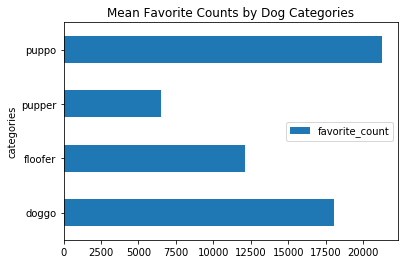

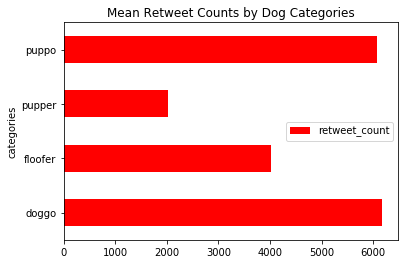

In [124]:
#Reading the data
twitter_archive_master = pd.read_csv("twitter_archive_master.csv")

#Selecting the required columns for the analysis
df_reactions_category = pd.concat([twitter_archive_master['dog_category'], twitter_archive_master['retweet_count'], twitter_archive_master['favorite_count']], axis=1)

#Filtering by non null values
df_reactions_category = df_reactions_category[df_reactions_category['dog_category'].notnull()]

#Grouping data
df_reactions_category = df_reactions_category.groupby(['dog_category']).mean()

#Data visualization
display(df_reactions_category)

df_reactions_category['categories'] = df_reactions_category.index

df_reactions_category.plot(x='categories', y='favorite_count', kind='barh', title="Mean Favorite Counts by Dog Categories")

df_reactions_category.plot(x='categories', y='retweet_count', kind='barh', title="Mean Retweet Counts by Dog Categories", color = 'r')

On the one hand, puppos are the most favorited followed by doggos, floofers and puppers. On the other hand, doggos are the most retweeted, followed by puppos, floofer and puppers. The distribution of these reactions leads us to our next question.

# How is the relationship between retweets and favorite counts in the WeRateDogs account?

In order to answer this question, is useful to visualize the relationship using a scatter plot and a regresion model. First, lets scatter plot the mentioned variables


Text(0, 0.5, 'Favorite Counts')

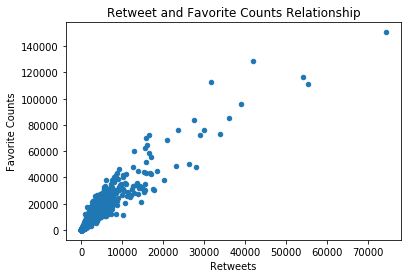

In [29]:
#Selecting the columns used for the analysis
df_reactions = pd.concat([twitter_archive_master['retweet_count'], twitter_archive_master['favorite_count']], axis=1)

#Data visualization
df_reactions.plot(x='retweet_count', y='favorite_count', title = 'Retweet and Favorite Counts Relationship', kind='scatter')

plt.xlabel('Retweets')

plt.ylabel('Favorite Counts')

Now we can plot a regression model in the same dataset using seaborn library.

Text(0, 0.5, 'Favorite Counts')

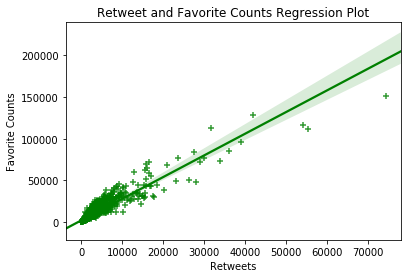

In [125]:
#Linear Regression model visualization
sns.regplot(x='retweet_count', y='favorite_count', data=df_reactions, color='g', marker='+')

plt.title('Retweet and Favorite Counts Regression Plot')

plt.xlabel('Retweets')

plt.ylabel('Favorite Counts')

The linear relationship is very clear. As we can see in the next correlation matrix, there is a positive relationship between retweet and favorite counts in the WeRateDogs Twitter account.

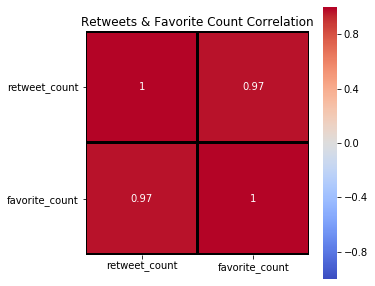

In [126]:
#Correlation Matrix Visualization
reactions_correlation = df_reactions.corr(method = 'spearman')

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(reactions_correlation, annot=True, linewidths=2, linecolor='black', cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True)

ax.set_yticklabels(reactions_correlation.index, rotation=0)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Retweets & Favorite Count Correlation')

plt.show()

# Which dog breeds have the best ratings?

To answer this question we will group by ratings and dog breeds.

First, we consider only those predictions that were detected as dogs and with a prediction confidence of over 0.7 by slicing the cleaned dataframe.

,prediction_confidence_1,prediction_is_a_dog_1,rating_numerator,rating_denominator,rating
breed_prediction_1,,,,,
clumber,0.946718,True,27.000000,10.0,2.700000
Gordon_setter,0.940724,True,14.000000,10.0,1.400000
black-and-tan_coonhound,0.854861,True,14.000000,10.0,1.400000
Afghan_hound,0.903712,True,13.000000,10.0,1.300000
curly-coated_retriever,0.733256,True,13.000000,10.0,1.300000
briard,0.982755,True,13.000000,10.0,1.300000
Leonberg,0.927021,True,13.000000,10.0,1.300000
Siberian_husky,0.786770,True,12.200000,10.0,1.220000
Samoyed,0.947903,True,12.043478,10.0,1.204348


Text(0, 0.5, 'Rating')

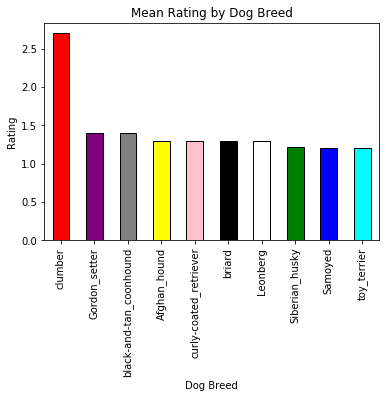

In [128]:
#Selecting the columns used for the analysis
df_reactions_breed = pd.concat([twitter_archive_master['breed_prediction_1'],
                                twitter_archive_master['prediction_confidence_1'],
                                twitter_archive_master['prediction_is_a_dog_1'],
                                twitter_archive_master['rating_numerator'], 
                                twitter_archive_master['rating_denominator']],
                               axis=1)

#Rating calculation
df_reactions_breed['rating'] = df_reactions_breed['rating_numerator'].astype(int) / df_reactions_breed['rating_denominator'].astype(int)

#Data filtering
df_reactions_breed = df_reactions_breed[(df_reactions_breed['prediction_is_a_dog_1'] == True) & (df_reactions_breed['prediction_confidence_1'] >= 0.7)]

#Data grouping and sorting
df_reactions_breed = df_reactions_breed.groupby(['breed_prediction_1']).mean()

df_reactions_breed = df_reactions_breed.sort_values(by=['rating'], ascending = False)[:10]

display(df_reactions_breed)

#Data visualization
df_reactions_breed['breed_prediction_1'] = df_reactions_breed.index

df_reactions_breed.plot(x='breed_prediction_1', y='rating', kind='bar', title="Mean Rating by Dog Breed", edgecolor='black',
                        color=['red', 'purple','grey' ,'yellow', 'pink','black', 'white', 'green', 'blue', 'cyan'])

plt.legend('', frameon=False)

plt.xlabel('Dog Breed')

plt.ylabel('Rating')

As we can see, the clumber spaniel is the breed with higher ratings, followed by black and tan coonhound. In the third place there are 4 breeds: afghan hound, curly-coated retriever, briard, and leonberg. The fourth, fifth and sixth place are siberian huskies, samoyed and toy terrier.